In [19]:
import sys
import os
import glob
from pathlib import Path
sys.path.append('./extract_patches_nonT.py')
import extract_patches_nonT as ep
from matplotlib import pyplot as plt
import numpy as np
import time
from PIL import Image
import cv2 
import pandas as pd
import openslide
os.getcwd()

'/home/wangyh/uro_biomarker/patho_AI/processing'

In [2]:
class Timer:
    def __init__(self):
        self._begin_time = None

    def tic(self):
        self._begin_time = time.perf_counter()

    def toc(self):
        return time.perf_counter() - self._begin_time

def show_info(show_values = False,**kws):
    length = 'no length'
    keys = 'not a dict'
    values = 'not a dict'
    shape = 'not a ndarray'
    size = 'not a ndarray'
    for key,x in kws.items():
        if hasattr(x,'__len__'):
            length = len(x)
        if isinstance(x,dict):
            keys = x.keys()
            values = x.values()
        if type(x) is np.ndarray or type(x) is cp.ndarray:
            shape = x.shape
            size = x.size
        print(key)
        print(f'allocated memory:{binary_conversion(x)}')
        print(f'\ntype:{type(x)} \nlen:{length}\nshape:{shape}\nsize:{size}\nkeys:{keys}\noriginal info:{x}\n')
        if show_values:
            print(f'\nvalues:{values}\n')

def null_or_not(x,pr = False):  #只要有一个元素不为0则不为0
    if type(x) is not np.ndarray:
        x = np.array(x)
    if pr:
        if x.any():
            print('not all 0')
        else:
            print('all 0')
    return x.any()

def show_dzg_info(dzg):
    print(f'level count:{dzg.level_count}')
    print(f'tile arrangement of last 3 level{dzg.level_tiles[-4:-1]}\ndimensions of each tile at last 3 level:{dzg.level_dimensions[-4:-1]}')

def pop_tile(dzg,level,save = False):
    row,col = dzg.level_tiles[level]
    saved = []
    if level<0:
        level = dzg.level_count + level
    for i in range(row):
        for j in range(col):
            if null_or_not(dzg.get_tile(level,(i,j))):
                saved.append((i,j))
                if not save:
                    print((i,j))
    if save:
        return saved

#point把黑色（0）转化成白色（255），threshold把<阈值的转化成白色（255），两者方向相反
def pixel_255(image,point = False,threshold = False):
    if type(image) is not np.ndarray:
        image = np.array(image)
        if point:
            image[image==0] = 255
        if threshold:
            image[image>threshold] = 255 
        return Image.fromarray(image)
    else:
        if point:
            image[image==0] = 255
        if threshold:
            image[image>threshold] = 255 
        return image

#通过cv显示图片
def imgshow(img_path):
    tiff = cv2.imread(img_path)
    plt.imshow(Image.fromarray(tiff))

#查看tiff文件path、info及图片
def tiff_checker(tiff_path):
    show_info(tiff_path = tiff_path)
    tif.imshow(tif.imread(tiff_path))

#同时展示多张图片
def ploting(rows,cols,figseq,
            figsize=(20,20),fontdict={'size':20},title = []):
    #figseq是一个4维的ndarray
    #rows,cols是展示图片的行/列数
    fig,axes = plt.subplots(rows,cols,figsize=figsize)
    fontdict = fontdict
    if rows != 1:
        for i in range(rows):
            for j in range(cols):
                if title:
                    axes[i,j].set_title(title[i*cols+j])
                else:
                    axes[i,j].set_title(f'{i}_{j}')
                axes[i,j].imshow(figseq[i*cols+j])
    else:
        for j in range(cols):
            if title:
                axes[j].set_title(title[j])
            else:
                axes[j].set_title(f'{j}')
            axes[j].imshow(figseq[j])


In [3]:
df = pd.read_csv('../config/full.csv')
uuids = df['dir_uuid']

In [ ]:
root_path = {
    'server':'/mnt/wangyh/TCGA_svs/',
    'desktop':'I:\\TCGA_bladder\\TCGA_bladder\\',
    'laptop':''
}
file_id = uuids[3] + '/'
rule =  {"tumor":{"excludes":["artificial","stroma","necrosis"]},
        'stroma':{"excludes":['artificial','necrosis']}}
timer = Timer()
file_path = root_path['server'] + file_id
svs_path = glob.glob(file_path + '*.svs')[0]
xml_path = glob.glob(file_path + '*.xml')[0]

slide = ep.get_slide(svs_path) #svs_path是一个list
mask_coords,classes = ep.AnnotationParser(xml_path)

annos = ep.Annotation(slide,xml_path,rule=rule)
# masked_tumor = ep.show_thumb_mask(annos['tumor'])
tumor_slide,non_tumor_slide = ep.get_mask_slide(annos) #返回一个Imageslide类

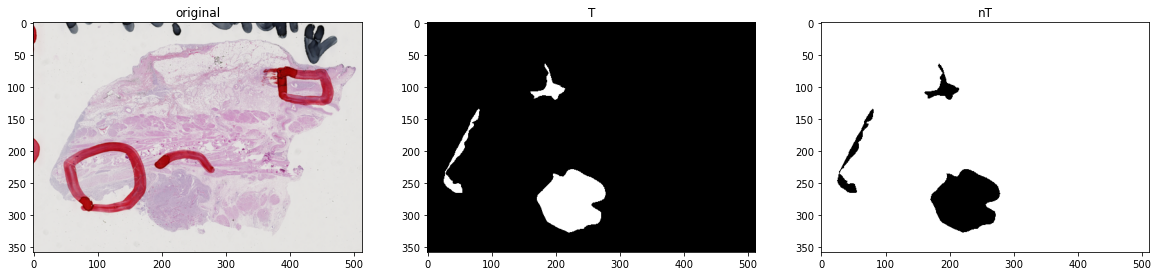

In [35]:
ploting(1,3,figseq=[slide.get_thumbnail((512,512)),pixel_255(tumor_slide.get_thumbnail((512,512)),threshold=0.1),pixel_255(non_tumor_slide.get_thumbnail((512,512)),threshold=0.1)],title = ['original','T','nT'])

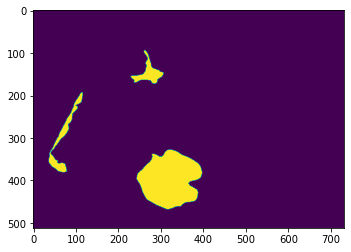

In [30]:
masked_tumor = ep.show_thumb_mask(annos['tumor'])

In [ ]:
#批量展示tumor mask

# figseq = []
# title = []
# for i in range(15):
#     file_id = uuids[i] + '/'
#     file_path = root_path['server'] + file_id
#     svs_path = glob.glob(file_path + '*.svs')[0]
#     xml_path = glob.glob(file_path + '*.xml')[0]
#     slide = ep.get_slide(svs_path) #svs_path是一个list
#     mask_coords,classes = ep.AnnotationParser(xml_path)

#     annos = ep.Annotation(slide,xml_path,rule=rule)
#     masked_tumor = ep.show_thumb_mask(annos['tumor'])
# #     tumor_slide = ep.get_mask_slide(annos) #返回一个Imageslide类
#     figseq.append(masked_tumor)
#     title.append(i)
# ploting(3,5,figseq=figseq,title=title)
    

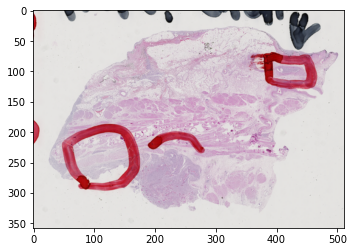

In [31]:
# 根据uuid展示单张图片
file_id = uuids[3] + '/'
file_path = root_path['server'] + file_id
svs_path = glob.glob(file_path + '*.svs')[0]
with openslide.OpenSlide(svs_path) as slide:
    tn = slide.get_thumbnail((512,512))
    plt.imshow(tn)

In [7]:
# timer.tic
# tumor_thumbnail = tumor_slide.get_thumbnail((1000,500))
# timer.toc

In [8]:
# figure = plt.figure(figsize=(25,10))
# original = plt.subplot(131)
# original.imshow(slide.get_thumbnail((1000,500)))
# mask = plt.subplot(132)
# mask.imshow(masked_tumor)
# tumorslide = plt.subplot(133)
# tumorslide.imshow(tumor_thumbnail)

In [9]:
# TILE_SIZE = 512
# slide_tiles,tumor_tiles = ep.get_tiles(slide,tumor_slide,tile_size = TILE_SIZE)

In [10]:
# tumor_tile_list = pop_tile(tumor_tiles,-3,save = True)
# tumor_tile_list

In [11]:
# onehot_pic(tumor_tiles.get_tile(16,(12,49)),0)  

In [12]:
# scales = ['5X','10X','20X','40X']
# extracted_case = []
# un_extracted_case = []
# tile_path = '../config/'
# level_count = slide_tiles.level_count
# levels=[level_count-4,level_count-3,level_count-2,level_count-1]
# try:
#     ep.extract_patches(levels,scales,tile_path,slide_tiles,tumor_tiles)
#     extracted_case.append(file_path)
# except Exception as e:
#     un_extracted_case.append(file_path)
#     print("something is wrong when extracting")
#     print("ERROR!",e)

In [13]:
# tiff = cv2.imread('../config/5X/10_3.tiff',1)
# plt.imshow(Image.fromarray(tiff))

In [14]:
# path_10 = '../config/10X/10_25.tiff' 
# path_20 = '../config/20X/100_10.tiff'
# path_40 = '../config/40X/100_33.tiff'
# imgshow(path_40)

In [44]:
import torch
print(torch.version.cuda)

None
